#### Helper Functions

In [4]:
import os
import glob
import csv
import pickle
import cv2
from tqdm.notebook import tqdm

def create_data_dict(data_dir, fold, class_map, type_):
    csv_data_train = {}
    csv_data_val = {}

    # Load training data
    for patient_id in fold[0]:
        if "OSCC" == class_map[type_]:
            for subtype_ in ["WD", "MD", "PD"]:
                data_folder = os.path.join(data_dir, "images", class_map[type_], subtype_, patient_id)
                for file_path in glob.glob(data_folder + "/*.png"):
                    csv_data_train[file_path] = type_
        else:
            data_folder = os.path.join(data_dir, "images", class_map[type_], patient_id)
            for file_path in glob.glob(data_folder + "/*.png"):
                csv_data_train[file_path] = type_

    # Load val data
    for patient_id in fold[1]:
        data_folder = os.path.join(data_dir, "images", class_map[type_], patient_id)
        if "OSCC" == class_map[type_]:
            for subtype_ in ["WD", "MD", "PD"]:
                data_folder = os.path.join(data_dir, "images", class_map[type_], subtype_, patient_id)
                for file_path in glob.glob(data_folder + "/*.png"):
                    csv_data_val[file_path] = type_

        else:
            data_folder = os.path.join(data_dir, "images", class_map[type_], patient_id)
            for file_path in glob.glob(data_folder + "/*.png"):
                csv_data_val[file_path] = type_  

    return csv_data_train, csv_data_val

def load_folds(path, type, num_folds=3):
    folds = {}
    for counter in range(num_folds):
        if type == "OSCC":
            folds[counter] = []
            for subtype in ["WD", "MD", "PD"]:
                subtype_fold_path = os.path.join(path, f"{type.lower()}-{subtype.lower()}-fold-{counter+1}.pkl")
                with open(subtype_fold_path, "rb") as file:
                    folds[counter].extend(pickle.load(file))
        else:
            fold_path = os.path.join(path, f"{type.lower()}-fold-{counter+1}.pkl")
            with open(fold_path, "rb") as file:
                folds[counter] = pickle.load(file)

    return folds

def save_to_csv(data, data_dir, num_fold, filename, class_map):
    csv_dir = os.path.join(data_dir, f"folds_data_{class_map[0].lower()}_{class_map[1].lower()}")
    os.makedirs(csv_dir, exist_ok=True)

    csv_file_path = os.path.join(csv_dir, f"fold_{num_fold}_{filename}.csv")
    with open(csv_file_path, 'w', newline='') as csvfile:
        fieldnames = ['path', 'label']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        # Write the header
        writer.writeheader()

        # Write the data
        for filename, label in data.items():
            writer.writerow({'path': filename[1:], 'label': label})

def create_center_cropped_patches(files, type_, save_dir):
    for file in tqdm(files):
        image = cv2.imread(file)
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Get the dimensions of the image
        H, W = image_gray.shape
        
        # Calculate the cropping coordinates
        top = max(0, (H - 520) // 2)
        bottom = min(H, top + 520)
        left = max(0, (W - 520) // 2)
        right = min(W, left + 520)
        
        # Center crop the image_gray
        image_gray_cropped = image_gray[top:bottom, left:right]

        file_name_split = file.split("/")
        base_name = file_name_split[-1]

        save_path = os.path.join(save_dir, base_name)
        print(save_path)
        cv2.imwrite(save_path, image_gray_cropped)

#### Define the Paths Here

In [7]:
data_dir = "../data/"
img_dir = "/media/KutumLabGPU/split_data_png_new/train"
class_map = {0: "OSMF", 1: "OSCC"}

#### Creates Pathces in BW (520x520) Format (Deprecated)

In [3]:
# # Create patches
# for oc_type in class_map.values():
#     # Skip if already created
#     if oc_type in os.listdir(os.path.join(data_dir, "images")):
#         continue
    
#     # Handle OSCC separately
#     if oc_type == "OSCC":
#         for subtype in ["WD", "MD", "PD"]:
#             path = os.path.join(img_dir, oc_type, subtype)
#             for pid in os.listdir(path):
#                 save_dir = os.path.join(data_dir, "images",  oc_type, subtype, pid)
#                 os.makedirs(save_dir, exist_ok=True)

#                 files = glob.glob(os.path.join(path, pid) + "/*.png")
#                 create_center_cropped_patches(files, oc_type, save_dir)
#     else:
#         path = os.path.join(img_dir, oc_type)
#         for pid in os.listdir(path):
#             save_dir = os.path.join(data_dir, "images",  oc_type, pid)
#             os.makedirs(save_dir, exist_ok=True)

#             files = glob.glob(os.path.join(path, pid) + "/*.png")
#             create_center_cropped_patches(files, oc_type, save_dir)

#### Generate Patches

In [ ]:
import cv2
import numpy as np
import os
from joblib import Parallel, delayed

def generate_patches(image_path, patch_size=(960, 960), stride=(480, 480)):
    # Read the image
    image = cv2.imread(image_path)
    height, width, _ = image.shape

    # Calculate the number of patches in each dimension
    num_patches_x = (width - patch_size[1]) // stride[1] + 1
    num_patches_y = (height - patch_size[0]) // stride[0] + 1

    # Generate patches
    patches = []
    for i in range(num_patches_y):
        for j in range(num_patches_x):
            # Calculate patch coordinates
            start_x = j * stride[1]
            start_y = i * stride[0]
            end_x = start_x + patch_size[1]
            end_y = start_y + patch_size[0]

            # Check if the patch goes out of image dimensions
            if end_x > width:
                start_x = width - patch_size[1]
                end_x = width
            if end_y > height:
                start_y = height - patch_size[0]
                end_y = height

            # Extract the patch from the image
            patch = image[start_y:end_y, start_x:end_x]
            patch = cv2.resize(patch, (256, 256))
            patches.append(patch)

    return patches

def process_patients(directory, save_dir, patch_size=(960, 960), stride=(480, 480)):
    for pid_dir in os.listdir(directory):
        pid_path = os.path.join(directory, pid_dir)
        save_path = os.path.join(save_dir, pid_dir)
        
        if os.path.isdir(pid_path):
            os.makedirs(save_path, exist_ok=True)
            
            for image_file in tqdm(os.listdir(pid_path)):
                image_path = os.path.join(pid_path, image_file)
                
                if os.path.isfile(image_path):
                    patches = generate_patches(image_path, patch_size, stride)
                    
                    # Save patches in the same patient directory
                    for i, patch in enumerate(patches):
                        patch_name = f"{os.path.splitext(image_file)[0]}_{i}.png"
                        print(os.path.join(save_path, patch_name))
                        cv2.imwrite(os.path.join(save_path, patch_name), patch)

# def process_patient(pid_path, save_path, patch_size, stride):
#     if os.path.isdir(pid_path):
#         os.makedirs(save_path, exist_ok=True)
#         for image_file in tqdm(os.listdir(pid_path)):
#             image_path = os.path.join(pid_path, image_file)
#             if os.path.isfile(image_path):
#                 patches = generate_patches(image_path, patch_size, stride)
#                 # Save patches in the same patient directory
#                 for i, patch in enumerate(patches):
#                     patch_name = f"{os.path.splitext(image_file)[0]}_{i}.png"
#                     cv2.imwrite(os.path.join(save_path, patch_name), patch)

# def process_patients(directory, save_dir, patch_size=(960, 960), stride=(480, 480), n_jobs=-1):
#     pid_dirs = [os.path.join(directory, pid_dir) for pid_dir in os.listdir(directory)]
#     save_dirs = [os.path.join(save_dir, pid_dir) for pid_dir in os.listdir(directory)]

#     Parallel(n_jobs=n_jobs)(
#         delayed(process_patient)(pid_path, save_path, patch_size, stride)
#         for pid_path, save_path in zip(pid_dirs, save_dirs)
#     )

def process_directory(directory, save_dir, patch_size=(960, 960), stride=(480, 480)):
    for oc_type in os.listdir(directory):
        if oc_type == "OSCC":
            for subtype in ["WD", "PD", "MD"]:
                oc_type_path = os.path.join(directory, oc_type, subtype)
                save_dir_ = os.path.join(save_dir, oc_type, subtype)
        else:
            oc_type_path = os.path.join(directory, oc_type)
            save_dir_ = os.path.join(save_dir, oc_type)
        
        if os.path.isdir(oc_type_path):
            os.makedirs(save_dir, exist_ok=True)
            process_patients(oc_type_path, save_dir_, patch_size, stride)

In [ ]:
directory = "/media/KutumLabGPU/split_data_png_new/train"
save_dir = "../data/images"
patch_size = (960, 960)
stride = (480, 480)
process_directory(directory, save_dir, patch_size, stride)

#### Creates CSV Files from Given Folds Information

In [8]:
# Load folds
out_1 = load_folds(os.path.join(data_dir, "train-folds"), class_map[0])
out_2 = load_folds(os.path.join(data_dir, "train-folds"), class_map[1])


for i in range(len(out_1)):
    csv_data_train_1, csv_data_val_1 = create_data_dict(data_dir, out_1[i], class_map, 0)
    csv_data_train_2, csv_data_val_2 = create_data_dict(data_dir, out_2[i], class_map, 1)

    csv_data_train = {**csv_data_train_1, **csv_data_train_2}

    csv_data_val = {**csv_data_val_1, **csv_data_val_2}

    save_to_csv(csv_data_train, data_dir, i+1, "train", class_map)
    save_to_csv(csv_data_val, data_dir, i+1, "val", class_map)

#### Test Visualization

In [2]:
import torch
from torchvision import transforms
import torchstain
import cv2

to_transform = cv2.cvtColor(cv2.imread("../data/images/OSCC/MD/003-035/HP23-20-S3-20_0.png"), cv2.COLOR_BGR2RGB)
target = cv2.cvtColor(cv2.imread("./target.png"), cv2.COLOR_BGR2RGB)

T = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x*255)
])

normalizer = torchstain.normalizers.ReinhardNormalizer(backend='torch')
normalizer.fit(T(target))

t_to_transform = T(to_transform)
norm = normalizer.normalize(I=t_to_transform)

(-0.5, 511.5, 511.5, -0.5)

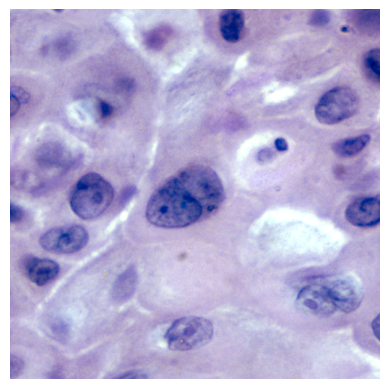

In [3]:
import matplotlib.pyplot as plt
plt.imshow(norm.numpy())
plt.axis('off')